In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import random, re, math
from collections import Counter, defaultdict, OrderedDict
from tqdm import tqdm, trange
from pprint import pprint
from matplotlib import pyplot as plt
import types, sys, os
sys.path.append("../scripts/formalism")
from dataset import *
from entropy import *
NumberTypes = (int, float, complex)

In [3]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
df = pd.read_csv("../data/sheets_icons/diffuser_icons_experiments - split3.csv",
                 header=0,
                 )
df = df.dropna(axis='rows', subset='Epoch')
df.set_index("Epoch", inplace=True)
df.index = df.index.astype(int)

In [4]:
df.head(3)

,1213_174529\nnum_objs=90,"1217_211800 trainable_parameters = [""attentions"", ""encoder_hid_proj""] (self_attn + cross_attn)","1218_155123 only_cross_attn=True (CA+CA) trainable_parameters = [""attentions"", ""encoder_hid_proj""] \n(cross_attn + cross_attn)",1214_123648 num_objs=30,"1218_161059 num_objs=30 trainable_parameters = [""attentions"", ""encoder_hid_proj""] (self_attn + cross_attn)",1214_165951 num_objs=60,"1218_093718 \nnum_objs=60 \ntrainable_parameters = [""attentions"", ""encoder_hid_proj""] \n(self_attn + cross_attn)",0203_173206\nnum_objs=20,0203_220547\nnum_objs=40,0203_220446\nnum_objs=50,0203_220305\nnum_objs=70,0203_220223\nnum_objs=80
Epoch,,,,,,,,,,,,
19,89.73 tr acc = 89.94,88.90 tr acc = 89.30,7.75 tr acc = 8.74,2.53 tr acc = 4.25,NaN,4.04 tr acc = 4.38,3.84 tr acc = 4.52\nsingle_obj acc (60-90) = 4...,NaN,2.5 tr acc = 3.01,1.06 tr acc = 1.51,7.97 tr acc = 9.03,16.67 tr acc = 17.26
39,99.93 tr acc = 100,99.99 tr acc = 99.98,92.38 tr acc = 91.90,4.94 tr acc = 7.93,NaN,57.82 tr acc = 64.41,73.59 tr acc = 77.09\nsingle_obj acc (60-90) =...,NaN,4.29 tr acc = 6.73,8.73 tr acc = 12.12,98.41 tr acc = 98.80,99.46 tr acc = 99.60
59,99.69 tr acc = 99.81,NaN,NaN,6.21 tr acc = 14.94,NaN,97.12 tr acc = 97.15,99.18 tr acc = 99.66\nsingle_obj acc (60-90) =...,NaN,4.49 tr acc = 12.12,82.61 tr acc = 86.94,98.7 tr acc = 98.76,99.86 tr acc = 99.98


In [5]:
df.columns.to_list()

['1213_174529\nnum_objs=90',
 '1217_211800 trainable_parameters = ["attentions", "encoder_hid_proj"] (self_attn + cross_attn)',
 '1218_155123 only_cross_attn=True (CA+CA) trainable_parameters = ["attentions", "encoder_hid_proj"] \n(cross_attn + cross_attn)',
 '1214_123648 num_objs=30',
 '1218_161059 num_objs=30 trainable_parameters = ["attentions", "encoder_hid_proj"] (self_attn + cross_attn)',
 '1214_165951 num_objs=60',
 '1218_093718 \nnum_objs=60 \ntrainable_parameters = ["attentions", "encoder_hid_proj"] \n(self_attn + cross_attn)',
 '0203_173206\nnum_objs=20',
 '0203_220547\nnum_objs=40',
 '0203_220446\nnum_objs=50',
 '0203_220305\nnum_objs=70',
 '0203_220223\nnum_objs=80']

In [6]:
od = df.to_dict(into=OrderedDict)

In [4]:
def get_data_teacc_epc(split, EPC, N):
    df = pd.read_csv(f"../data/sheets_icons/diffuser_icons_experiments - {split}.csv",
                    header=0,
                    )
    df = df.dropna(axis='rows', subset='Epoch')
    df.set_index("Epoch", inplace=True)
    df.index = df.index.astype(int)
    od = df.to_dict(into=OrderedDict)
    
    data = defaultdict(list)

    for n in df.columns.to_list():
        if "num_objs=" in n and not '[' in n:
            num_objs = int(re.findall(r'num_objs=(\d+)', n)[0])
            if num_objs not in N: continue
            #print(num_objs)
            Y, X = [], []
            for epc in EPC:
                if not epc in od[n]: 
                    continue
                record = od[n][epc]
                if isinstance(record, NumberTypes) and math.isnan(record): 
                    continue
                X.append(epc)
                try: Y.append(float(re.findall(r'(\d*\.?\d+)\s+tr acc', record)[0]))
                except:
                    print(record)
                    raise
            data[num_objs] = (X, Y)
    return data

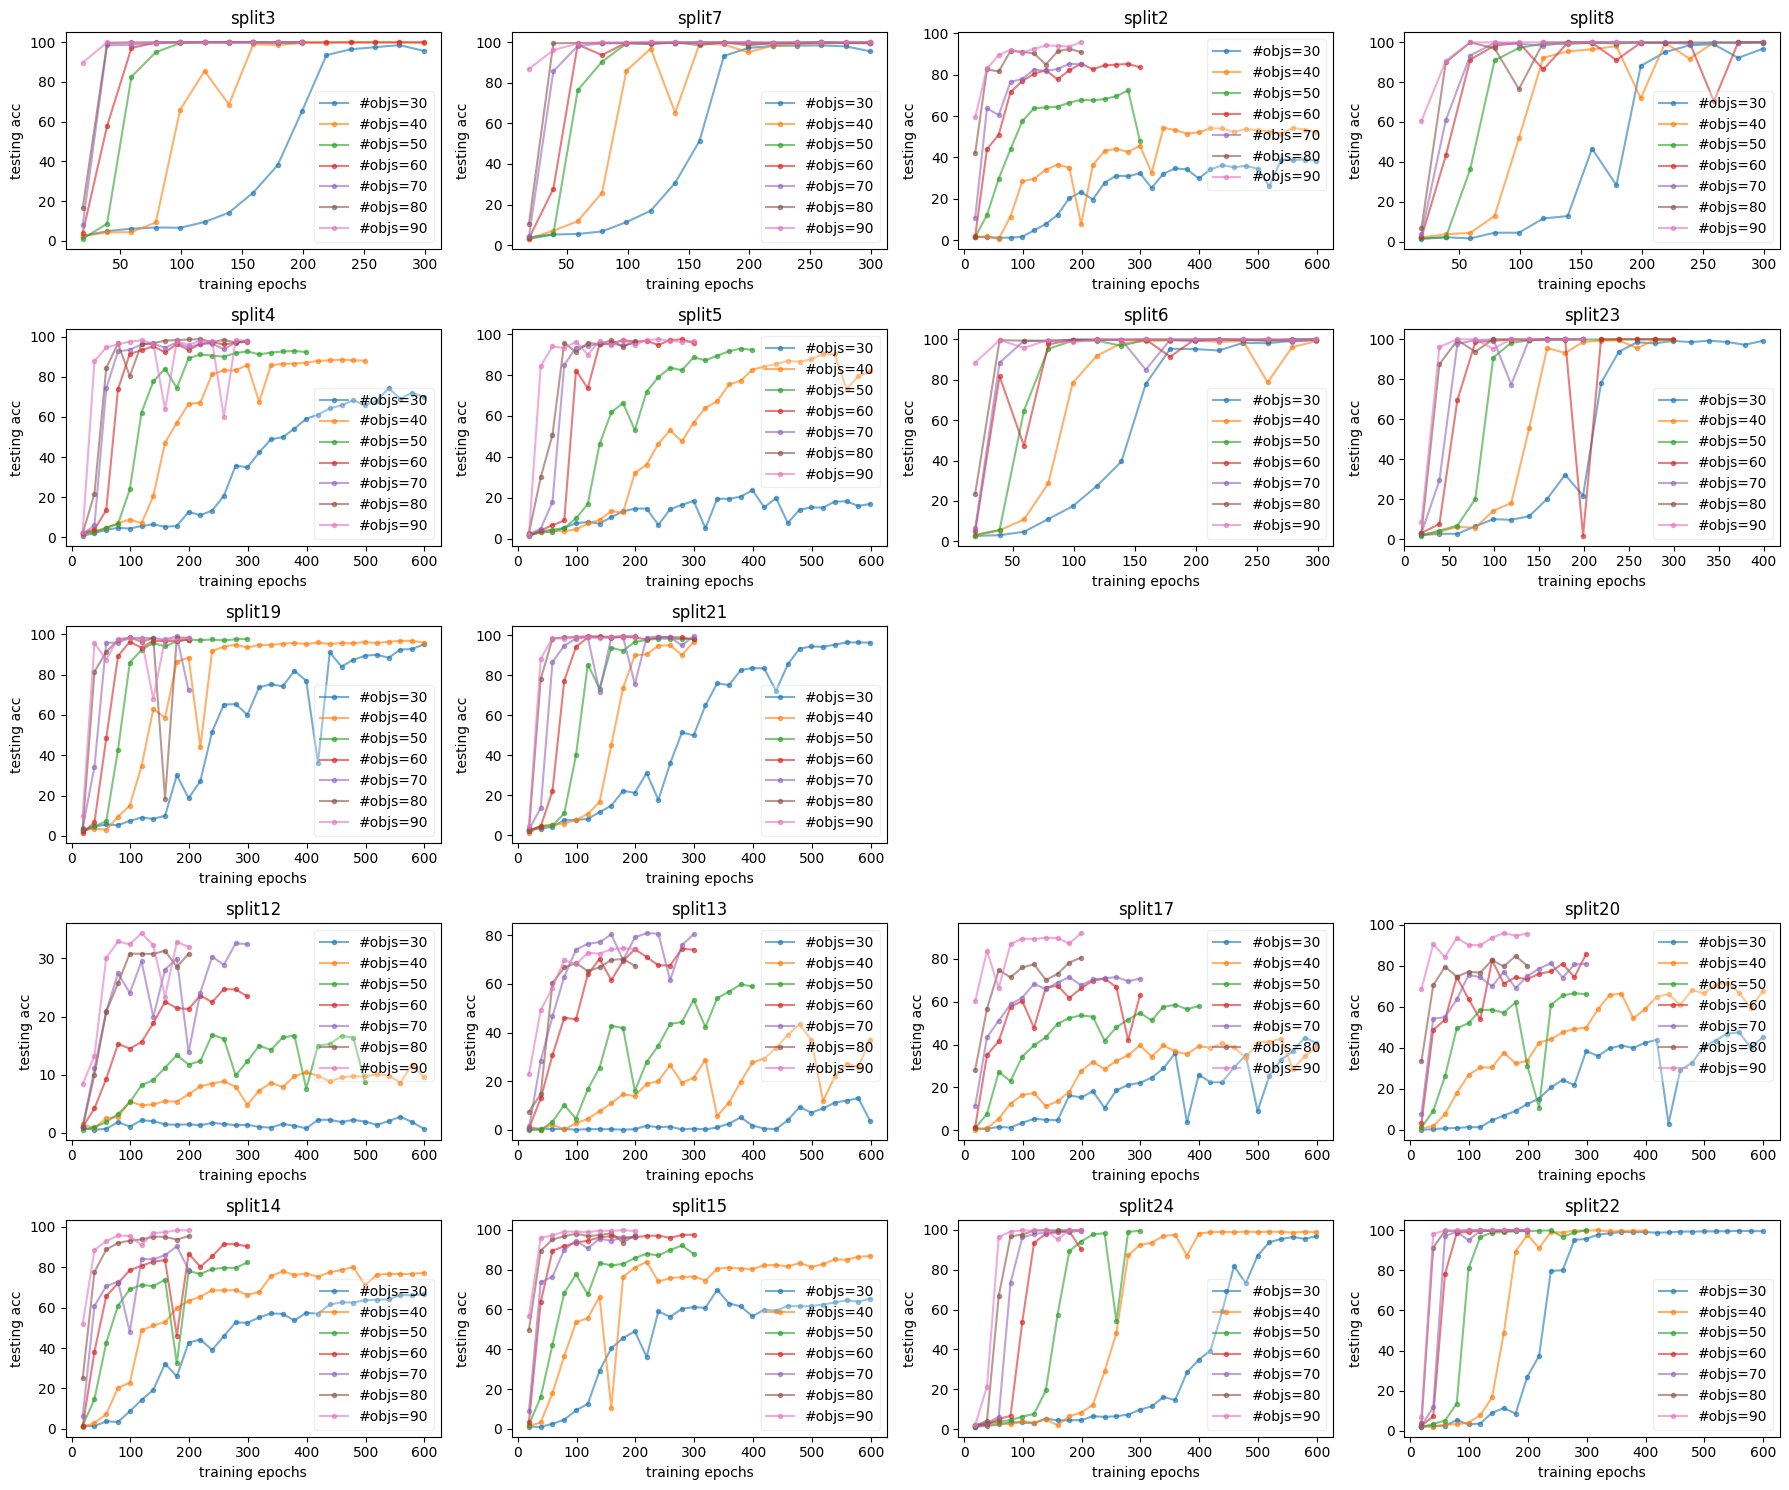

In [7]:
EPC = list(range(19, 600, 20))
N = list(range(30, 91, 10))

fig = plt.figure(figsize=(18, 15))
for i, s in enumerate([3,7,2,8,4,5,6,23,19,21,-1,-1,12,13,17,20,14,15,24,22]):
    ax = fig.add_subplot(5, 4, i+1)
    if s == -1: 
        ax.set_axis_off()
        continue
    split = f"split{s}"
    for n in N:
        data = get_data_teacc_epc(split, EPC, N)
        try: ax.plot(data[n][0], data[n][1], ".-", alpha=0.6, label=f"#objs={n}")
        except: 
            pprint(data)
            raise
    ax.set_xlabel("training epochs")
    ax.set_ylabel("testing acc")
    ax.set_title(split)
    ax.legend(framealpha=0.3)
    #print(f"finish split {s}")
fig.tight_layout()
plt.show()

In [5]:
""" x = #epc, y = #objs """
EPC_TO_STEPS = {
    "split2": "lambda x, y: int(y*(y-1)*x)",
    "split3": "lambda x, y: int(y*(y-1)*x)",
    "split4": "lambda x, y: int((y**2/2 - y)*x)",
    "split5": "lambda x, y: int((y**2/2)*x)",
    "split6": "lambda x, y: int((y**2 - 2*y)*x)",
    "split7": "lambda x, y: int(y*(y-1)*x)",
    "split8": "lambda x, y: int(y*(y-1)*x) - int(y/2)*x",
    "split12": "lambda x, y: int((y**2/2)*x)",
    "split13": "lambda x, y: int(y*(y-1)*x)",
    "split14": "lambda x, y: int((2*y - y//4 - 2) * (y//4) * 2 * x)",
    "split15": "lambda x, y: int((2*y - y//3 - 2) * (y//3) * 2 * x)",
    "split17": "lambda x, y: int((y**2 - 2*y*(y//4) + (y//4)**2 - y + 2*(y//4)) * 2 * x)",
    "split20": "lambda x, y: int((y**2 - 2*y*(y//6) + (y//6)**2 - y + 2*(y//6)) * 2 * x)",
    "split22": "lambda x, y: int(y * (y//6) * 4 * x)",
    "split24": "lambda x, y: int(y * (y//10) * 4 * x)",
    "split23": "lambda x, y: int(y * (y//3) * 2 * x)",
    "split19": "lambda x, y: int((18*(y**2)/25 - 0.4*y) * x)",
    "split21": "lambda x, y: int((y**2/2 + 2*(y//20)*(y - y//20 - 1)) *  x)"
}


In [6]:
def get_data_teacc_steps(split, EPC, N):
    df = pd.read_csv(f"../data/sheets_icons/diffuser_icons_experiments - {split}.csv",
                    header=0,
                    )
    df = df.dropna(axis='rows', subset='Epoch')
    df.set_index("Epoch", inplace=True)
    df.index = df.index.astype(int)
    od = df.to_dict(into=OrderedDict)
    
    data = defaultdict(list)

    for n in df.columns.to_list():
        if "num_objs=" in n and not '[' in n:
            num_objs = int(re.findall(r'num_objs=(\d+)', n)[0])
            if num_objs not in N: continue
            #print(num_objs)
            epc_to_steps = eval(EPC_TO_STEPS[split])
            Y, X = [], []
            for epc in EPC:
                if not epc in od[n]: 
                    continue
                record = od[n][epc]
                if isinstance(record, NumberTypes) and math.isnan(record): 
                    continue
                if epc_to_steps(epc+1, num_objs) > 1e6: continue
                X.append(epc_to_steps(epc+1, num_objs)/16000)
                Y.append(float(re.findall(r'(\d*\.?\d+)\s+tr acc', record)[0]))
            data[num_objs] = (X, Y)
    return data

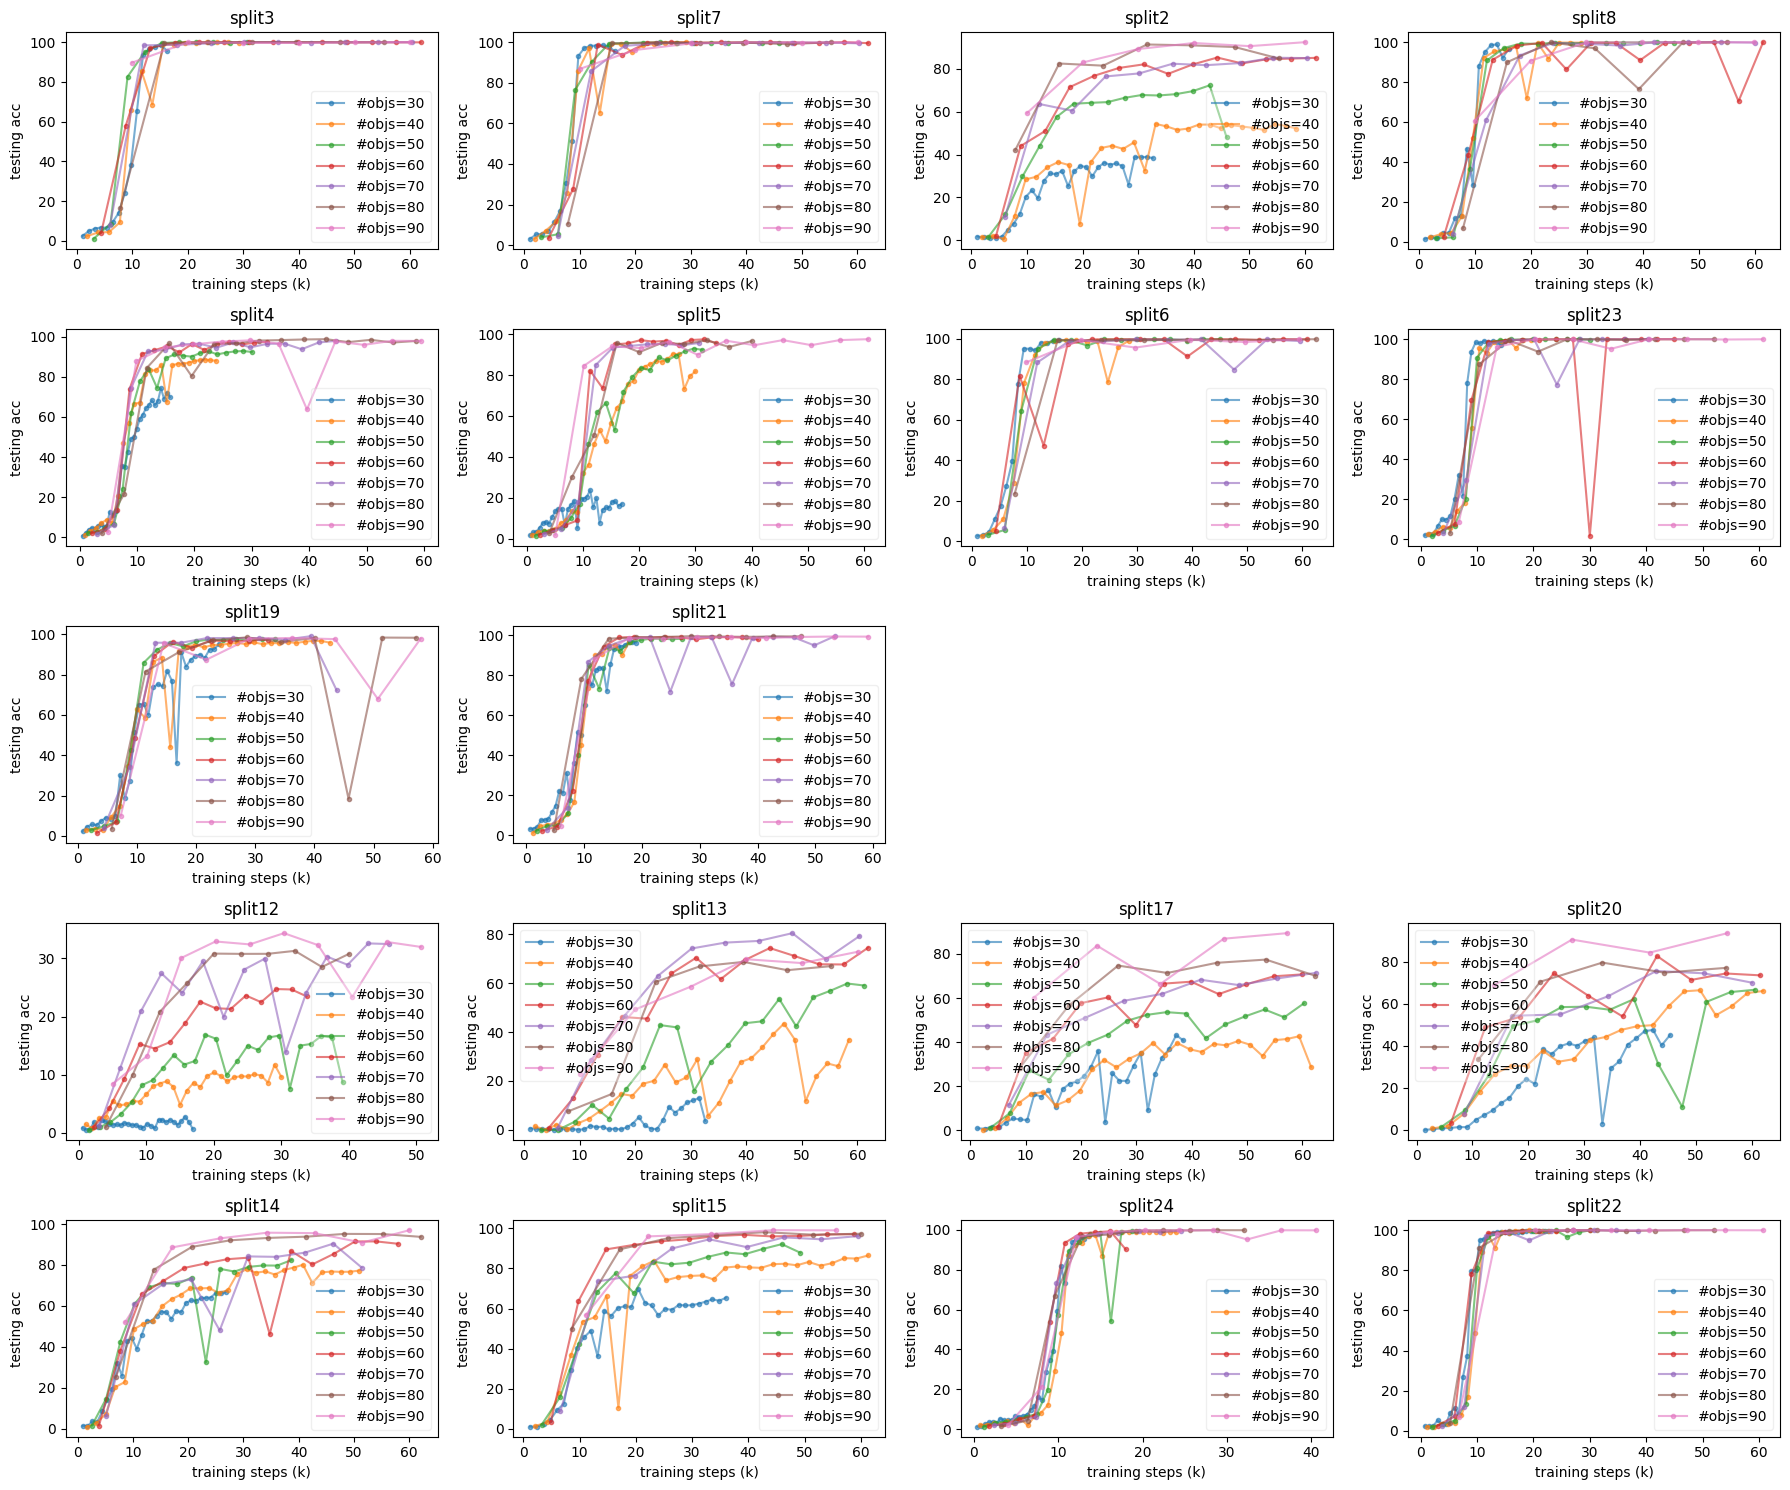

In [10]:
EPC = list(range(19, 600, 20))
N = list(range(30, 91, 10))

fig = plt.figure(figsize=(18, 15))
for i, s in enumerate([3,7,2,8,4,5,6,23,19,21,-1,-1,12,13,17,20,14,15,24,22]):
    ax = fig.add_subplot(5, 4, i+1)
    if s == -1: 
        ax.set_axis_off()
        continue
    split = f"split{s}"
    
    for n in N:
        data = get_data_teacc_steps(split, EPC, N)
        ax.plot(data[n][0], data[n][1], ".-", alpha=0.6, label=f"#objs={n}")
    ax.set_xlabel("training steps (k)")
    ax.set_ylabel("testing acc")
    ax.set_title(split)
    ax.legend(framealpha=0.3)

fig.tight_layout()
plt.show()

In [7]:
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
from cycler import cycler

#cmap = plt.get_cmap('tab10')
#cmap.colors
colors = list(matplotlib.colormaps['tab10'].colors)
CMAP = colors + ['navy', 'olive', 'peru', 'deeppink', 'lightgreen', 'limegreen', 'gold', 'aqua', 'mediumorchid', 'darkred', 'teal']

In [38]:
entropy_funcs = [
    #("concept_centric_entropy3(num_nouns, num_relations, df)", 1, False),
    #("concept_centric_entropy4(num_nouns, num_relations, df)", 1, False),
    #("concept_centric_entropy5(num_nouns, num_relations, df)", 1, False),
    #("relation_centric_entropy3(num_nouns, num_relations, df)", 1, False),
    #("relation_centric_entropy4(num_nouns, num_relations, df)", 1, False),
    #("relation_centric_entropy5(num_nouns, num_relations, df)", 1, False),
    #("divergence(num_nouns, num_relations, df)", 1, False),
    #("divergence2(num_nouns, num_relations, df)", 1, False),
    #("divergence3(num_nouns, num_relations, df)", 1, False),
    #("concept_role_entropy(num_nouns, df)", 1, False),
    #("concept_role_entropy2(num_nouns, df)", 1, False),
    #("concept_role_entropy(num_nouns, df)", 1, True),
    #("concept_role_entropy2(num_nouns, df)", 1, True),
    #"role_association(num_nouns, df)",
    #"role_association2(num_nouns, df)",
    #("concept_entropy(num_nouns, df)", 1, False),
    #("concept_entropy2(num_nouns, df)", 1, False),
    #("concept_entropy0(num_nouns, df)", 1, False),
    ("np.log(2) - concept_role_index_entropy(num_nouns, df)", 1, False), 
    ("np.log(2) - concept_role_index_entropy(num_nouns, df)", 1, True), 
]

def incompleteness_penalty(split, num_nouns, transpose):
    # transpose = True: linguistic, transpose = False: image
    if transpose:
        d = {
            "split5": 0.5+0.5,
            "split19": 0.4+0.4,
        }
        return d[split] if split in d else 0
    else:
        d = {
            "split12": 0.5+0.5,
            "split13": 0.5,
            "split17": 2*(num_nouns//4)/num_nouns,
            "split20": 2*(num_nouns//6)/num_nouns
        }
        return d[split] if split in d else 0

In [20]:
import scipy.stats as stats

def get_ci(x, y, p_value=0.9):
    p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
    y_model = np.polyval(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

    x2 = np.linspace(np.min(x), np.max(x), 100)
    y2 = np.polyval(p, x2)

    # Statistics
    n = len(y)                                                # number of observations
    m = p.size                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = stats.t.ppf(p_value, n - m)                              # t-statistic; used for CI and PI bands

    # Estimates of Error in Data/Model
    resid = y - y_model                                        # residuals; diff. actual data from predicted values                                    # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)  
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    return ci, x2, y2

In [62]:
def get_data_teacc_score(split, EPC, N, score_func, sign, transpose=False):
    df = pd.read_csv(f"../data/sheets_icons/diffuser_icons_experiments - {split}.csv",
                    header=0,
                    )
    df = df.dropna(axis='rows', subset='Epoch')
    df.set_index("Epoch", inplace=True)
    df.index = df.index.astype(int)
    od = df.to_dict(into=OrderedDict)
    
    data = []

    epc_to_steps = eval(EPC_TO_STEPS[split])
    for n in df.columns.to_list():
        if "num_objs=" in n and not '[' in n:
            num_nouns = int(re.findall(r'num_objs=(\d+)', n)[0])
            if num_nouns not in N: continue

            df = create_synthetic_df(split, num_nouns, transpose=transpose)
            score = eval(score_func) * sign
            #score += incompleteness_penalty(split, num_nouns, transpose)
            delta = epc_to_steps(20, num_nouns)/16000

            gap = 0
            TEACC, TRACC = [], []
            for epc in EPC:
                if not epc in od[n]: continue
                record = od[n][epc]
                if isinstance(record, NumberTypes) and math.isnan(record): 
                    # three_largest_teacc = sorted(TEACC, reverse=True)[:3]
                    # teacc = np.mean(three_largest_teacc)
                    # three_largest_tracc = sorted(TRACC, reverse=True)[:3]
                    # tracc = np.mean(three_largest_tracc)
                    # gap += tracc - teacc
                    # continue
                    break
                try: teacc, tracc = re.findall(r'(\d*\.?\d+)\s+tr acc\s?=\s?(\d*\.?\d+)', record)[0]
                except:
                    print(f"failed to regex teacc and tracc from record: {record}")
                    raise
                TEACC.append(float(teacc))
                TRACC.append(float(tracc))
                #gap += (float(tracc) - float(teacc))
            #print(len(TEACC), len(TRACC))
            gap = np.sum([r-e for r, e in zip(TRACC, TEACC)])
            data.append((score, gap/(len(TEACC)), num_nouns))
    res = [x[:2] for x in sorted(data, key=lambda i: i[-1])]
    return res
    

13it [00:03,  4.16it/s]
13it [00:03,  4.08it/s]


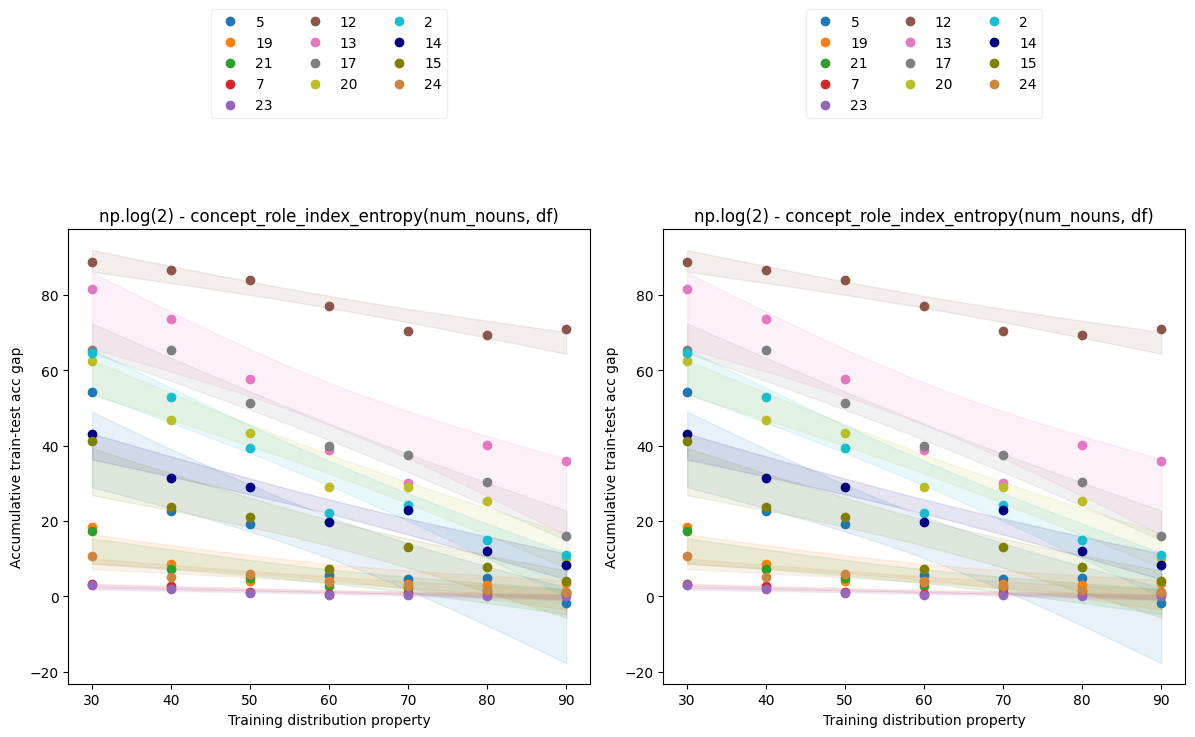

In [63]:
EPC = list(range(19, 600, 20))
N = list(range(30, 91, 10))

fig = plt.figure(figsize=(18, 12))
for i, f in enumerate(entropy_funcs):
    ax = fig.add_subplot(2, 3, i+1)
    #ax.set_prop_cycle(cycler('color', CMAP))

    for j, s in tqdm(enumerate([5,19,21,7,23,12,13,17,20,2,14,15,24])): #[3,7,2,8,4,5,6,23,19,21,12,13,17,20,14,15,24,22]):
        
        split = f"split{s}"
        #with HiddenPrints(): 
        data = get_data_teacc_score(split, EPC, N, *f)
        #ax.scatter([d[0] for d in data], [d[1] for d in data], label=split)
        
        Y = [d[1] for d in data]
        ax.plot(N, Y, "o", label=s, color=CMAP[j])
        ci, x2, y2 = get_ci(N, Y, 0.9)
        ax.fill_between(x2, y2 + ci, y2 - ci, color=CMAP[j], alpha=0.1)
    
    ax.set_xlabel("Training distribution property")
    ax.set_ylabel("Accumulative train-test acc gap")
    ax.set_title(f[0])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.5),
          ncol=3, framealpha=0.3)

fig.tight_layout()
plt.show()


## Plot Latent Diffusion Results 

In [1]:
import pandas as pd
from matplotlib import colors
import numpy as np
import random, re, math, types, sys, os, matplotlib, json
from collections import Counter, defaultdict, OrderedDict
from tqdm import tqdm, trange
from pprint import pprint
from matplotlib import pyplot as plt
#import seaborn as sns
NumberTypes = (int, float, complex)
sys.path.append("../scripts/diffuser_icons/")
from dataset import *


### Synthetic Images

In [2]:
df = pd.read_csv("../data/sheets_icons/diffuser_icons_experiments - latent_diffusion.csv",header=0,)
#df = df.dropna(axis='rows', subset='Epoch')
df.set_index("Epoch", inplace=True)
df.index = df.index.astype(int)
od = df.to_dict(into=OrderedDict)

EPC = list(range(19, 600, 20))  
data = defaultdict(list)
for n in df.columns.to_list():     
    TRACCs, TEACCs, X = [], [], []
    for epc in EPC:
        record = od[n][epc]
        if isinstance(record, NumberTypes) and math.isnan(record): continue
        X.append(epc)
        try:
            tracc = float(re.findall(r'tr acc = (\d*\.?\d+)', record)[0])
            teacc = float(re.findall(r'(\d*\.?\d+)\s+tr acc', record)[0])
            TEACCs.append(teacc)
            TRACCs.append(tracc)
        except:
            print(record)
            raise
    data[n] = (X, TEACCs, TRACCs)

In [3]:
for n in data:
    X, TEACCs, TRACCs = data[n]
    if len(TEACCs) == 0: gap = -1
    else: 
        gap1 = str(round(sum([max(0, j-i) for i, j in zip(TEACCs, TRACCs)]) / len(TEACCs), 2))
        gap2 = str(round(sum([j-i for i, j in zip(TEACCs, TRACCs)]) / len(TEACCs), 2))
    print(f"split {n:2s}, gap1 = {gap1:5s}, gap2 = {gap2:5s}")

split 12, gap1 = 92.61, gap2 = 92.61
split 13, gap1 = 79.45, gap2 = 79.45
split 17, gap1 = 60.39, gap2 = 60.39
split 20, gap1 = 59.95, gap2 = 59.95
split 2 , gap1 = 70.82, gap2 = 70.82
split 14, gap1 = 47.73, gap2 = 47.73
split 15, gap1 = 45.52, gap2 = 45.52
split 24, gap1 = 10.37, gap2 = 10.37
split 8 , gap1 = 5.6  , gap2 = 5.6  
split 5 , gap1 = 50.88, gap2 = 50.87
split 19, gap1 = 8.58 , gap2 = 8.58 
split 21, gap1 = 11.36, gap2 = 11.36
split 7 , gap1 = 2.0  , gap2 = 1.86 
split 23, gap1 = 2.55 , gap2 = 2.55 


In [4]:
for n in data:
    X, TEACCs, TRACCs = data[n]
    if len(TEACCs) == 0: max_teacc = -1
    else: max_teacc = str(max(TEACCs))
    print(f"split {n:2s}, max_teacc = {max_teacc:5s}")

split 12, max_teacc = 2.87 
split 13, max_teacc = 15.75
split 17, max_teacc = 45.66
split 20, max_teacc = 45.47
split 2 , max_teacc = 32.18
split 14, max_teacc = 61.4 
split 15, max_teacc = 61.54
split 24, max_teacc = 96.01
split 8 , max_teacc = 99.88
split 5 , max_teacc = 26.74
split 19, max_teacc = 95.65
split 21, max_teacc = 94.08
split 7 , max_teacc = 98.97
split 23, max_teacc = 99.3 


In [3]:
metrics = {
    12: "%(O1)=50  , %(O2)=50  , balance=0    , coverage=25",
    13: "%(O1)=100, %(O2)=0    , balance=68  , coverage=50",
    17: "%(O1)=75  , %(O2)=75  , balance=68  , coverage=57",
    20: "%(O1)=84  , %(O2)=84  , balance=79  , coverage=70",
    2: "%(O1)=97, %(O2)=97, balance=71  , coverage=50",
    14: "%(O1)=100, %(O2)=100, balance=79  , coverage=43",
    15: "%(O1)=100, %(O2)=100, balance=84  , coverage=55",
    24: "%(O1)=100, %(O2)=100, balance=100, coverage=20",
    8: "%(O1)=100, %(O2)=100, balance = 100, coverage=50",
    5: "%(O1)=50  , %(O2)=50  , balance=0  , coverage=25",
    19: "%(O1)=60  , %(O2)=60  , balance=33, coverage=36",
    21: "%(O1)=100, %(O2)=100, balance=36, coverage=30",
    7: "%(O1)=100, %(O2)=100, balance=71, coverage=50",
    23: "%(O1)=100, %(O2)=100, balance=95, coverage=33",
}

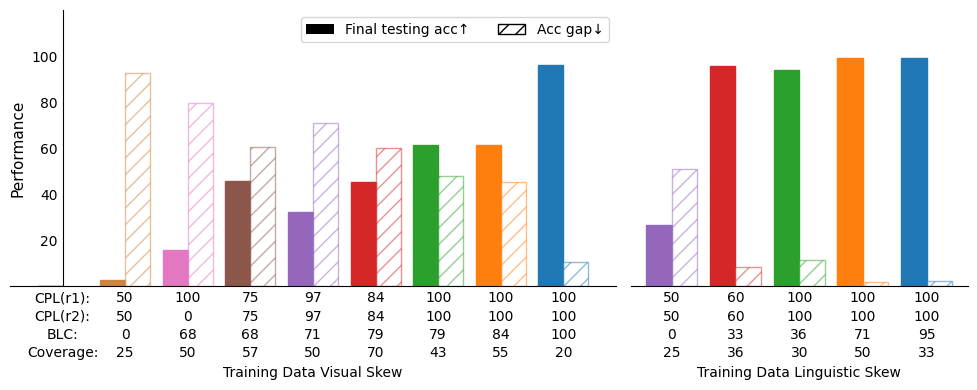

In [30]:
colors = ['peru'] + list(matplotlib.colormaps['tab10'].colors)[::-1][3:] + list(matplotlib.colormaps['tab10'].colors)[::-1][5:]

width = 0.4  # the width of the bars
figsize = (10, 4) #(10, 3) for rebuttal
linespacing = 1.4 # 1.3 for rebuttal

fig, [ax, ax2] = plt.subplots(
      1, 2, figsize=figsize, sharex='col', sharey='row',
      gridspec_kw={'width_ratios': [9, 5],}
)


ax.bar(-1, 0, width, color="black", label="Final testing acc\u2191")
ax.bar(-1, 0, width, color="white", edgecolor="black", hatch="//", label="Acc gap\u2193")
xtick_labels = ["CPL(r1):\nCPL(r2):\nBLC:\nCoverage:"]

splits_for_plot1 = [12, 13, 17, 2, 20, 14, 15, 24]
data_for_plot = defaultdict(list)
for i, n in enumerate(splits_for_plot1):
      CPLr1, CPLr2, BLC, Coverage = metrics[n].split(", ")
      xtick_labels.append("{}\n{}\n{}\n{}".format(
            CPLr1.strip().split("=")[-1],
            CPLr2.strip().split("=")[-1],
            BLC.strip().split("=")[-1],
            Coverage.strip().split("=")[-1]
      ))

      X, TEACCs, TRACCs = data[str(n)]
      data_for_plot['split'].append(X)
      if len(TEACCs) == 0: gap = -1
      else: gap = round(sum([max(0, j-i) for i, j in zip(TEACCs, TRACCs)]) / len(TEACCs), 2)
      if len(TEACCs) == 0: max_teacc = -1
      else: max_teacc = max(TEACCs)
      
      rect = ax.bar(i, max_teacc, width, color=colors[i], edgecolor=colors[i])
      rect = ax.bar(i+width, gap, width, color="white", edgecolor=colors[i], hatch="//", alpha=0.5)

splits_for_plot2 = [5, 19, 21, 7, 23]
xtick_labels2 = []
offset = len(splits_for_plot1)
data_for_plot = defaultdict(list)
for i, n in enumerate(splits_for_plot2):
      CPLr1, CPLr2, BLC, Coverage = metrics[n].split(", ")
      xtick_labels2.append("{}\n{}\n{}\n{}".format(
            CPLr1.strip().split("=")[-1],
            CPLr2.strip().split("=")[-1],
            BLC.strip().split("=")[-1],
            Coverage.strip().split("=")[-1]
      ))

      X, TEACCs, TRACCs = data[str(n)]
      data_for_plot['split'].append(X)
      if len(TEACCs) == 0: gap = -1
      else: gap = round(sum([max(0, j-i) for i, j in zip(TEACCs, TRACCs)]) / len(TEACCs), 2)
      if len(TEACCs) == 0: max_teacc = -1
      else: max_teacc = max(TEACCs)
      
      rect = ax2.bar(i+offset, max_teacc, width, color=colors[i+offset], edgecolor=colors[i+offset])
      rect = ax2.bar(i+offset+width, gap, width, color="white", edgecolor=colors[i+offset], hatch="//", alpha=0.5)

ax.set_ylabel("Performance", fontsize=11)
ax.set_xlabel('Training Data Visual Skew', fontsize=10)
ax2.set_xlabel("Training Data Linguistic Skew", fontsize=10)

ax.set_xticks(np.arange(-1, len(splits_for_plot1)) + width/2, xtick_labels, linespacing=linespacing)
ax2.set_xticks(np.arange(len(splits_for_plot1), len(splits_for_plot1+splits_for_plot2)) + width/2, xtick_labels2, linespacing=linespacing)

ax.tick_params(axis='both', which='both', length=0)
ax2.tick_params(axis='both', which='both', length=0)

ax.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top', 'left']].set_visible(False)
ax.spines['left'].set_position(('data', -0.8))

ax.set_yticks([20, 40, 60, 80, 100])
ax.legend(loc='upper right', ncol=2)
ax.set_ylim(0, 120)
ax2.set_ylim(0, 120)


plt.tight_layout()
plt.show() 

#fig.savefig(f"/home/ubuntu/clevr_control/notebooks/figures/latent_diffusion_synthetic.png", dpi=150, bbox_inches='tight')
fig.savefig(f"/home/yingshac/workspace/clevr_control/notebooks/figures/latent_diffusion_synthetic_CR_edition.png", dpi=150, bbox_inches='tight')

In [4]:
### PMD
os.chdir("../scripts/diffuser_icons/")
#sys.path.append("../formalism")
#from entropy import create_synthetic_df


In [5]:
max_num_objs = 30
with open("../../data/nouns/all_nouns.txt", "r") as f:
    nouns = [x.strip() for x in f.readlines()][:max_num_objs]
print(len(nouns), nouns[0])
with open("../../data/matplotlib/unicode.jsonl", "r", encoding="unicode-escape") as f: 
    icons = [(json.loads(x)[0], json.loads(x)[2]) for x in f.readlines()][:max_num_objs]
print(len(icons), icons[0])

30 soda
30 ('∦', 'DejaVuSans')


In [6]:
# gather concept freqeucies
def extract_two_concepts(s):
    t = s.replace(".", "").split()
    return t[1], t[-1]
def extract_two_concepts_at_roles(s):
    t = s.replace(".", "").split()
    t1, t2 = t[1], t[-1]
    if "bottom" in s:
        t2, t1 = t1, t2
    return t1, t2
canvas_size = (32, 32) #(128, 128)
icon_size = 32 #128
icon_fontsize = 28 #120

In [7]:
### read latent diffusion results

df = pd.read_csv("../../data/sheets_icons/diffuser_icons_experiments - latent_diffusion.csv",header=0,)
df.set_index("Epoch", inplace=True)
df.index = df.index.astype(int)
od = df.to_dict(into=OrderedDict)

EPC = list(range(19, 600, 20))  
data = defaultdict(list)
for n in df.columns.to_list():     
    TRACCs, TEACCs, X = [], [], []
    for epc in EPC:
        record = od[n][epc]
        if isinstance(record, NumberTypes) and math.isnan(record): continue
        X.append(epc)
        try:
            tracc = float(re.findall(r'tr acc = (\d*\.?\d+)', record)[0])
            teacc = float(re.findall(r'(\d*\.?\d+)\s+tr acc', record)[0])
            TEACCs.append(teacc)
            TRACCs.append(tracc)
        except:
            print(record)
            raise
    data[n] = (X, TEACCs, TRACCs)

In [8]:
### read pixel diffusion results
### borrowed from overleaf_figure.ipynb, then modified

def get_data_best_teacc_and_gap(split, EPC, N):
    df = pd.read_csv(f"/home/yingshac/workspace/clevr_control/data/sheets_icons/diffuser_icons_experiments - {split}.csv",
                    header=0,
                    )
    df = df.dropna(axis='rows', subset='Epoch')
    df.set_index("Epoch", inplace=True)
    df.index = df.index.astype(int)
    od = df.to_dict(into=OrderedDict)
    data = []

    for n in df.columns.to_list():
        if "num_objs=" in n and not '[' in n:
            num_nouns = int(re.findall(r'num_objs=(\d+)', n)[0])
            if num_nouns not in N: continue
            gap = 0
            TEACC, TRACC = [], []
            for epc in EPC:
                if not epc in od[n]: continue
                record = od[n][epc]
                if isinstance(record, NumberTypes) and math.isnan(record): 
                    break
                try: teacc, tracc = re.findall(r'(\d*\.?\d+)\s+tr acc\s?=\s?(\d*\.?\d+)', record)[0]
                except:
                    print(f"failed to regex teacc and tracc from record: {record}")
                    raise
                TEACC.append(float(teacc))
                TRACC.append(float(tracc))
            gap = np.sum([r-e for r, e in zip(TRACC, TEACC)])
            data.append((gap/len(TEACC), max(TEACC), num_nouns))
    gap = [x[0] for x in sorted(data, key=lambda i: i[-1])]
    best_teacc = [x[1] for x in sorted(data, key=lambda i: i[-1])]

    return gap, best_teacc
    

450 1290 900
870 870 1740
1026 714 2052
870 870 1740
1210 530 2420
960 780 1920
360 1380 720
900 840 1800


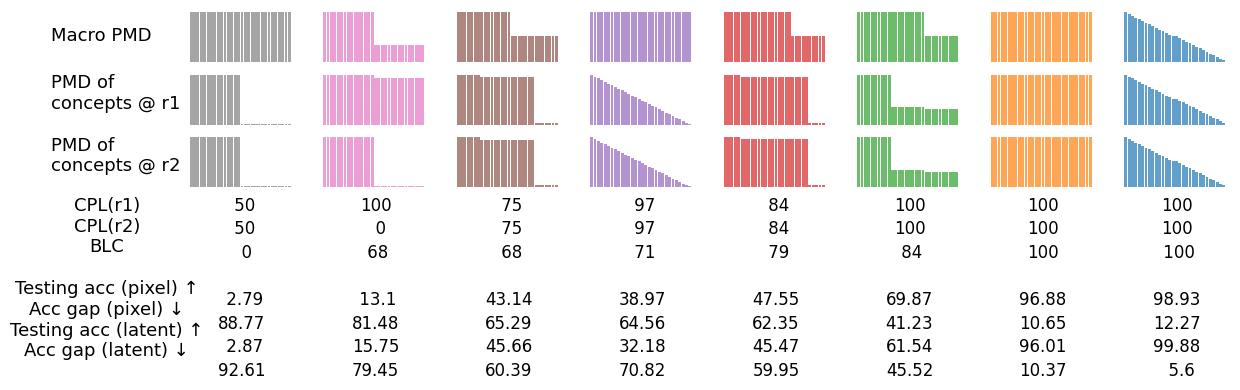

In [10]:
### Plot for camera-ready
### add both pixel and latent diffusion results
### better spacing and readability

colors = list(matplotlib.colormaps['tab10'].colors)[::-1][2:]
splits = [12, 13, 17, 2, 20, 15, 24, 8]
nrows = 3
ncols = 1+len(splits)

fig = plt.figure(figsize=(1.4*(ncols), 4))

fontsize = 13
width = 0.85
alpha = 0.7
for i, s in enumerate(splits):
    split = f"split{s}"
    train_pairs, test_pairs = eval(f"create_data_{split}")(nouns, icons, canvas_size=canvas_size, icon_size=icon_size, fontsize=icon_fontsize)
    c = Counter([w for x in train_pairs for w in extract_two_concepts(x[0])])
    c_r1 = Counter([extract_two_concepts_at_roles(x[0])[0] for x in train_pairs])
    c_r2 = Counter([extract_two_concepts_at_roles(x[0])[1] for x in train_pairs])
    total_freq = sum(c.values())
    print(len(train_pairs), len(test_pairs), total_freq)
    
    ax = fig.add_subplot(nrows, ncols, i+2)
    ax.bar(np.arange(len(c)), np.array(sorted(c.values(), reverse=True)) / total_freq, width=width, color=colors[i], alpha=alpha)
    # if i==0: 
    #     ax.set_ylabel("Macro-PMD\nof concepts", fontsize=fontsize)
    #     ax.set_xlim((-5, 30))
    ax.get_xaxis().set_visible(False)
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.set_yticks([])

    ax = fig.add_subplot(nrows, ncols, ncols+i+2)
    ax.bar(np.arange(len(c)), np.array(sorted(c_r1.values(), reverse=True) + [0.0006*total_freq]*(len(c) - len(c_r1))) / total_freq, width=width, alpha=alpha, color=colors[i])
    # if i==0: 
    #     ax.set_ylabel("@ r1 PMD\nof concepts", fontsize=fontsize)
    #     ax.set_xlim((-5, 30))
    ax.get_xaxis().set_visible(False)
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.set_yticks([])

    ax = fig.add_subplot(nrows, ncols, 2*ncols+i+2)
    ax.bar(np.arange(len(c)), np.array(sorted(c_r2.values(), reverse=True) + [0.0008*total_freq]*(len(c) - len(c_r2))) / total_freq, width=width, alpha=alpha, color=colors[i])
    # if i==0: 
    #     ax.set_ylabel("@ r2 PMD\nof concepts", fontsize=fontsize)
    #     ax.set_xlim((-5, 30))
    #ax.get_xaxis().set_visible(False)
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.set_yticks([])

    
    CPLr1, CPLr2, BLC, Coverage = metrics[s].split(", ")
    X, TEACCs, TRACCs = data[str(s)]
    if len(TEACCs) == 0: gap_latent = -1
    else: gap_latent = round(sum([max(0, j-i) for i, j in zip(TEACCs, TRACCs)]) / len(TEACCs), 2)
    if len(TEACCs) == 0: max_teacc_latent = -1
    else: max_teacc_latent = max(TEACCs)
    
    #ax = fig.add_subplot(nrows, ncols, 3*len(splits)+i+1)
    #ax.set_ylim((0, 2))
    #ax.set_xlim((0, 2.5))

    gap_pixel, max_teacc_pixel = get_data_best_teacc_and_gap(split, list(range(19, 600, 20)), [30])
    gap_pixel, max_teacc_pixel = round(gap_pixel[0], 2), round(max_teacc_pixel[0], 2)
    
    xtick_positions, xtick_labels = [], []
    xtick_positions.append(15)
    xtick_labels.append("{:>3}\n{:>3}\n{:>3}\n\n{:>5}\n{:>5}\n{:>5}\n{:>5}".format(
        CPLr1.strip().split("=")[-1],
        CPLr2.strip().split("=")[-1],
        BLC.strip().split("=")[-1],
        max_teacc_pixel,
        gap_pixel,
        max_teacc_latent,
        gap_latent
    ))
    ax.set_xticks(xtick_positions, xtick_labels, linespacing=1.4, fontsize=12)
    ax.set_yticks([])
    ax.tick_params(bottom = False) 
    #break

ax = fig.add_subplot(nrows, ncols, 1)
xy = (0, 0.3)
ax.annotate("Macro PMD", xy=(0, 0.4), fontsize=fontsize)
ax.set_axis_off()
ax = fig.add_subplot(nrows, ncols, ncols+1)
ax.annotate("PMD of\nconcepts @ r1", xy=xy, fontsize=fontsize)
ax.set_axis_off()
ax = fig.add_subplot(nrows, ncols, 2*ncols+1)
ax.annotate("PMD of\nconcepts @ r2", xy=xy, fontsize=fontsize)

ax.set_xticks([0.5], ["CPL(r1)\nCPL(r2)\nBLC\n\nTesting acc (pixel) \u2191\nAcc gap (pixel) \u2193\nTesting acc (latent) \u2191\nAcc gap (latent) \u2193"], linespacing=1.2, fontsize=fontsize)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.set_yticks([])
ax.tick_params(bottom = False) 
    

fig.tight_layout()
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

fig.savefig(f"/home/yingshac/workspace/clevr_control/notebooks/figures/splits_for_image_skew_pmd_CR_edition.png", dpi=180, bbox_inches='tight')


450 1290 900
870 870 1740
1026 714 2052
870 870 1740
1210 530 2420
960 780 1920
360 1380 720
900 840 1800


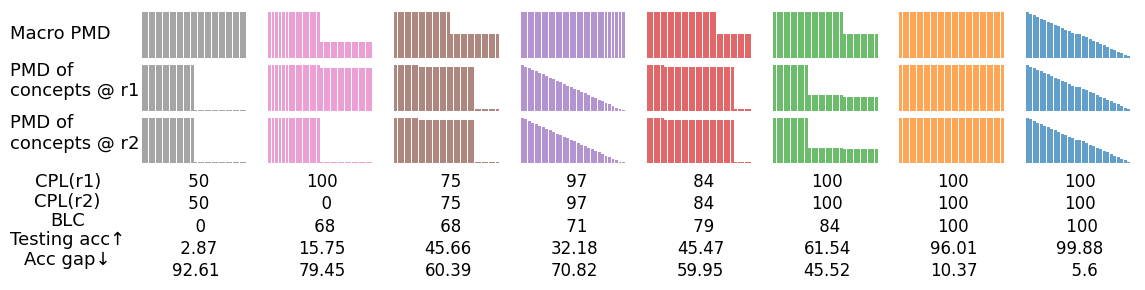

In [10]:
### Plot for rebuttal

colors = list(matplotlib.colormaps['tab10'].colors)[::-1][2:]
splits = [12, 13, 17, 2, 20, 15, 24, 8]
nrows = 3
ncols = 1+len(splits)

fig = plt.figure(figsize=(1.3*(ncols), 3))

fontsize = 13
width = 0.85
alpha = 0.7
for i, s in enumerate(splits):
    split = f"split{s}"
    train_pairs, test_pairs = eval(f"create_data_{split}")(nouns, icons, canvas_size=canvas_size, icon_size=icon_size, fontsize=icon_fontsize)
    c = Counter([w for x in train_pairs for w in extract_two_concepts(x[0])])
    c_r1 = Counter([extract_two_concepts_at_roles(x[0])[0] for x in train_pairs])
    c_r2 = Counter([extract_two_concepts_at_roles(x[0])[1] for x in train_pairs])
    total_freq = sum(c.values())
    print(len(train_pairs), len(test_pairs), total_freq)
    
    ax = fig.add_subplot(nrows, ncols, i+2)
    ax.bar(np.arange(len(c)), np.array(sorted(c.values(), reverse=True)) / total_freq, width=width, color=colors[i], alpha=alpha)
    # if i==0: 
    #     ax.set_ylabel("Macro-PMD\nof concepts", fontsize=fontsize)
    #     ax.set_xlim((-5, 30))
    ax.get_xaxis().set_visible(False)
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.set_yticks([])

    ax = fig.add_subplot(nrows, ncols, ncols+i+2)
    ax.bar(np.arange(len(c)), np.array(sorted(c_r1.values(), reverse=True) + [0.0006*total_freq]*(len(c) - len(c_r1))) / total_freq, width=width, alpha=alpha, color=colors[i])
    # if i==0: 
    #     ax.set_ylabel("@ r1 PMD\nof concepts", fontsize=fontsize)
    #     ax.set_xlim((-5, 30))
    ax.get_xaxis().set_visible(False)
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.set_yticks([])

    ax = fig.add_subplot(nrows, ncols, 2*ncols+i+2)
    ax.bar(np.arange(len(c)), np.array(sorted(c_r2.values(), reverse=True) + [0.0008*total_freq]*(len(c) - len(c_r2))) / total_freq, width=width, alpha=alpha, color=colors[i])
    # if i==0: 
    #     ax.set_ylabel("@ r2 PMD\nof concepts", fontsize=fontsize)
    #     ax.set_xlim((-5, 30))
    #ax.get_xaxis().set_visible(False)
    ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
    ax.set_yticks([])

    
    CPLr1, CPLr2, BLC, Coverage = metrics[s].split(", ")
    X, TEACCs, TRACCs = data[str(s)]
    if len(TEACCs) == 0: gap = -1
    else: gap = round(sum([max(0, j-i) for i, j in zip(TEACCs, TRACCs)]) / len(TEACCs), 2)
    if len(TEACCs) == 0: max_teacc = -1
    else: max_teacc = max(TEACCs)
    
    #ax = fig.add_subplot(nrows, ncols, 3*len(splits)+i+1)
    #ax.set_ylim((0, 2))
    #ax.set_xlim((0, 2.5))
    
    xtick_positions, xtick_labels = [], []
    xtick_positions.append(15)
    xtick_labels.append("{:>3}\n{:>3}\n{:>3}\n{:>5}\n{:>5}".format(
        CPLr1.strip().split("=")[-1],
        CPLr2.strip().split("=")[-1],
        BLC.strip().split("=")[-1],
        max_teacc,
        gap
    ))
    ax.set_xticks(xtick_positions, xtick_labels, linespacing=1.3, fontsize=12)
    ax.set_yticks([])
    ax.tick_params(bottom = False) 
    #break

ax = fig.add_subplot(nrows, ncols, 1)
xy = (0, 0.3)
ax.annotate("Macro PMD", xy=(0, 0.4), fontsize=fontsize)
ax.set_axis_off()
ax = fig.add_subplot(nrows, ncols, ncols+1)
ax.annotate("PMD of\nconcepts @ r1", xy=xy, fontsize=fontsize)
ax.set_axis_off()
ax = fig.add_subplot(nrows, ncols, 2*ncols+1)
ax.annotate("PMD of\nconcepts @ r2", xy=xy, fontsize=fontsize)

ax.set_xticks([0.5], ["CPL(r1)\nCPL(r2)\nBLC\nTesting acc\u2191\nAcc gap\u2193"], linespacing=1.1, fontsize=fontsize)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.set_yticks([])
ax.tick_params(bottom = False) 
    

fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.show()

#fig.savefig(f"/home/yingshac/workspace/clevr_control/notebooks/figures/splits_for_image_skew_pmd.png", dpi=180, bbox_inches='tight')


### Natural Images (What'sUp)

In [32]:
metrics = {
    'D': [100, 100, 100, 48],
    'F': [100, 100, 100, 53],
    'I': [100, 100, 80, 37],
    'J': [100, 100, 100, 53],
    'K': [100, 100, 100, 44],
    'G': [50, 100, 63, 47],
    'A': [80, 73, 77, 50],
    'B': [87, 87, 75, 49],
    'H': [100, 100, 73, 44],
    'C': [93, 93, 82, 47],
    'E': [100, 100, 88, 49],
    'Z': [100, 50, 63, 47],
    'U': [80, 73, 77, 50],
    'V': [87, 87, 75, 49],
    'T': [100, 100, 73, 44],
    'W': [93, 93, 82, 47],
    'X': [100, 100, 88, 49],
}

In [35]:
df = pd.read_csv("/home/yingshac/workspace/clevr_control/data/sheets_icons/diffuser_icons_experiments - whatsup_results_latent.csv",header=0,)
#df = df.dropna(axis='rows', subset='Epoch')
df.set_index("Epoch", inplace=True)
df.index = df.index.astype(int)
od = df.to_dict(into=OrderedDict)

EPC = list(range(199, 6000, 200))  
data = defaultdict(list)
for n in df.columns.to_list():     
    TRACCs, TEACCs, X = [], [], []
    for epc in EPC:
        record = od[n][epc]
        if isinstance(record, NumberTypes) and math.isnan(record): continue
        X.append(epc)
        try:
            tracc = float(re.findall(r'tr acc = (\d*\.?\d+)', record)[0])
            teacc = float(re.findall(r'(\d*\.?\d+)\s+tr acc', record)[0])
            TEACCs.append(teacc)
            TRACCs.append(tracc)
        except:
            print(record)
            raise
    data[n] = (X, TEACCs, TRACCs)

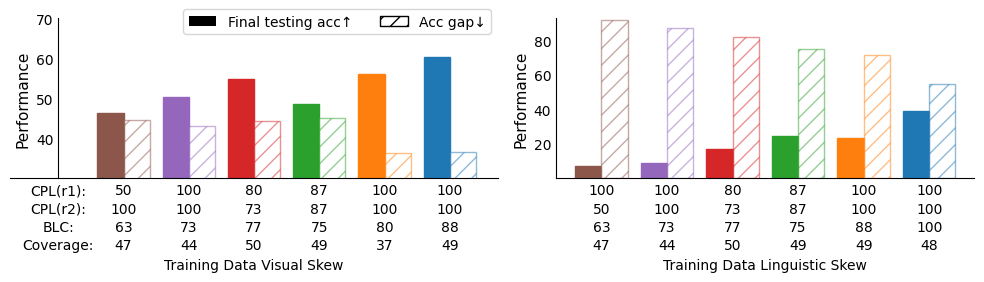

In [36]:
colors = list(matplotlib.colormaps['tab10'].colors)[::-1][4:] + list(matplotlib.colormaps['tab10'].colors)[::-1][4:]

width = 0.4  # the width of the bars
figsize = (10, 3) # (10, 2.5) for rebuttal
linespacing = 1.4 # 1.3 for rebuttal

fig, [ax, ax2] = plt.subplots(
      1, 2, figsize=figsize, sharex='col', #sharey='row',
      gridspec_kw={'width_ratios': [7, 6],}
)


ax.bar(-1, 0, width, color="black", label="Final testing acc\u2191")
ax.bar(-1, 0, width, color="white", edgecolor="black", hatch="//", label="Acc gap\u2193")
xtick_labels = ["CPL(r1):\nCPL(r2):\nBLC:\nCoverage:"]

splits_for_plot1 = 'GHABIE'
data_for_plot = defaultdict(list)
for i, n in enumerate(splits_for_plot1):
      CPLr1, CPLr2, BLC, Coverage = metrics[n] #.split(", ")
      xtick_labels.append("{}\n{}\n{}\n{}".format(
            CPLr1, CPLr2, BLC, Coverage
      ))

      X, TEACCs, TRACCs = data[str(n)]
      data_for_plot['split'].append(X)
      if len(TEACCs) == 0: gap = -1
      else: gap = round(sum([max(0, j-i) for i, j in zip(TEACCs, TRACCs)]) / len(TEACCs), 2)
      if len(TEACCs) == 0: max_teacc = -1
      else: max_teacc = max(TEACCs)
      
      rect = ax.bar(i, max_teacc, width, color=colors[i], edgecolor=colors[i])
      rect = ax.bar(i+width, gap, width, color="white", edgecolor=colors[i], hatch="//", alpha=0.5)

splits_for_plot2 = 'ZTUVXD'
xtick_labels2 = []
offset = len(splits_for_plot1)
data_for_plot = defaultdict(list)
for i, n in enumerate(splits_for_plot2):
      CPLr1, CPLr2, BLC, Coverage = metrics[n] # .split(", ")
      xtick_labels2.append("{}\n{}\n{}\n{}".format(
            CPLr1, CPLr2, BLC, Coverage
      ))

      X, TEACCs, TRACCs = data[str(n)]
      data_for_plot['split'].append(X)
      if len(TEACCs) == 0: gap = -1
      else: gap = round(sum([max(0, j-i) for i, j in zip(TEACCs, TRACCs)]) / len(TEACCs), 2)
      if len(TEACCs) == 0: max_teacc = -1
      else: max_teacc = max(TEACCs)
      
      rect = ax2.bar(i+offset, max_teacc, width, color=colors[i+offset], edgecolor=colors[i+offset])
      rect = ax2.bar(i+offset+width, gap, width, color="white", edgecolor=colors[i+offset], hatch="//", alpha=0.5)

ax.set_ylabel("Performance", fontsize=11)
ax2.set_ylabel("Performance", fontsize=11)
ax.set_xlabel('Training Data Visual Skew', fontsize=10)
ax2.set_xlabel("Training Data Linguistic Skew", fontsize=10)

ax.set_xticks(np.arange(-1, len(splits_for_plot1)) + width/2, xtick_labels, linespacing=linespacing)
ax2.set_xticks(np.arange(len(splits_for_plot1), len(splits_for_plot1+splits_for_plot2)) + width/2, xtick_labels2, linespacing=linespacing)

ax.tick_params(axis='both', which='both', length=0)
ax2.tick_params(axis='both', which='both', length=0)

ax.spines[['right', 'top']].set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_position(('data', -0.8))

ax.set_yticks([40, 50, 60, 70])
ax2.set_yticks([20, 40, 60, 80])
ax.legend(loc='upper right', ncol=2, bbox_to_anchor=[1, 1.1])
ax.set_ylim(30, 70)
ax2.set_ylim(0, 93)


plt.tight_layout()
plt.show() 

#fig.savefig(f"/home/yingshac/workspace/clevr_control/notebooks/figures/latent_diffusion_whatsup.png", dpi=150, bbox_inches='tight')
fig.savefig(f"/home/yingshac/workspace/clevr_control/notebooks/figures/latent_diffusion_whatsup_CR_edition.png", dpi=150, bbox_inches='tight')